# Gain modulation of synaptic inputs by network state in auditory cortex in vivo

If you use some of this code, please cite:

Reig et al. (2015). "Gain modulation of synaptic inputs by network state in auditory cortex in vivo." J Neurosci 35(6): 2689-2702.

## Abstract

The cortical network recurrent circuitry generates spontaneous
activity organized into Up (active) and Down (quiescent) states during
slow-wave sleep or anesthesia. These different states of cortical
activation gain modulate synaptic transmission. However, the reported
modulation that Up states impose on synaptic inputs is disparate in
the literature, including both increases and decreases of
responsiveness. Here, we tested the hypothesis that such disparate
observations may depend on the intensity of the stimulation. By means
of intracellular recordings, we studied synaptic transmission during
Up and Down states in rat auditory cortex in vivo. Synaptic potentials
were evoked either by auditory or electrical (thalamocortical,
intracortical) stimulation while randomly varying the intensity of the
stimulus. Synaptic potentials evoked by the same stimulus intensity
were compared in Up/Down states. Up states had a scaling effect on the
stimulus-evoked synaptic responses: the amplitude of weaker responses
was potentiated whereas that of larger responses was maintained or
decreased with respect to the amplitude during Down states. We used a
computational model to explore the potential mechanisms explaining
this nontrivial stimulus-response relationship. During Up/Down states,
there is different excitability in the network and the neuronal
conductance varies. We demonstrate that the competition between
presynaptic recruitment and the changing conductance might be the
central mechanism explaining the experimentally observed
stimulus-response relationships. We conclude that the effect that
cortical network activation has on synaptic transmission is not
constant but contingent on the strength of the stimulation, with a
larger modulation for stimuli involving both thalamic and cortical
networks.

In [22]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot') # because it's nice !
from scipy.special import erf # needed in the calculus

In [23]:
###############################################
############# cortical parameters #############
###############################################


## ---- membrane parameters
Gl, Cm , El = 10e-9, 200e-12, -65e-3 
Ee, Ei = 0, -80e-3 # synaptic reversal potential
# integrate and fire properties
Vthre=-50e-3; refrac = 5e-3 ; 
## ---- excitatory synaptic conductances
Qe, Te = 0.4e-9, 7.3e-3
## ---- inhibitory synaptic conductances
Qi, Ti = 1.2e-9, 5e-3
Ntot_cort = 10000

## ---- high conductance state parameters
ge_up_mean, ge_up_var = 7e-9, 3e-9
gi_up_mean, gi_up_var = 20e-9, 8e-9
## ---- low conductance state parameters
ge_down_mean, ge_down_var = 1e-10, 2e-11
gi_down_mean, gi_down_var = 2e-10, 5e-11

## ---- network parameters
connectivity = 0.02 # connection probability between neurons
g = 0.25 # 25 % of inhibitory neurons

## ---- cortical stimulation 
r0_cort = .3 # 100 um
rmax_cort = 1 # 1 mm
Ntot_cort = 10000 # total neuron number

###############################################
############# thalamic parameters #############
###############################################

## for the thalamic activation function, we 
mVm_down_thal, sVm_down_thal, Tm_down_thal = -64e-3, 4e-3, 20e-3 # Down state Vm statistics
mVm_up_thal, sVm_up_thal, Tm_up_thal = -61e-3, 5e-3, 0.7*Tm_down_thal # Down state Vm statistics
## thalamic stimulation 
r0_thal = .3 # 100 um
rmax_thal = 1. # .1 mm
Ntot_thal = 2000 # total neuron number, 1/10 the cortical one !!

########## thalamo-cortical afference
Qe_thal = 5*Qe # stronger synapse, see e.g. Bruno & Sakmann
Te_thal = Te
thal_connec = 0.02

## Calculus

The important functions for the study (i.e. the interesting part)

In [24]:
## --------------------------------------------------
## Evoked depolarization 
## --------------------------------------------------

def PSP(t, Nsyn, Qsyn, Tsyn, Tm, Cm, E, mVm):
    """ function that give the PSP after the linearization of Kuhn et al. 2004"""
    if abs(Tm-Tsyn)>1e-10:
        A = Tsyn*Qsyn*Tm/(Cm*(Tm-Tsyn))*(E-mVm)
        psp = Nsyn*A*(np.exp(-t/Tm)-np.exp(-t/Tsyn))
    else:
        psp = Nsyn*Qsyn*t*(E-mVm)/Cm*np.exp(-t/Tm)
    return psp

## ---------------------------------------------------------------
## Vm fluctuations as a function of the exc. and inh. conductances
## ---------------------------------------------------------------

def rudolph_calc(mGe, mGi, sGe, sGi):
    """ Rudoplh and Destexhe 2005 calculus of mean and variance of the membrane
    potential given 2 O.U. processes for the excitatory and inhibitory conductance"""
    # note in 2017, this can be improved, see the shotnoise analysis of later papers
    Tm =Cm/(Gl+mGe+mGi)
    TeB, TiB = Te*Tm/(Te+Tm), Ti*Tm/(Ti+Tm)
    kl, ke, ki = 2*Cm*Gl, 2*Cm*mGe, 2*Cm*mGi
    ue, ui=TeB*sGe*sGe, TiB*sGi*sGi
    S0, S1=kl+ke+ue+ki+ui, kl*El+ke*Ee+ue*Ee+ki*Ei+ui*Ei
    mVm=S1/S0
    sVm= np.sqrt( ( S0**2 * (ue*Ee**2+ui*Ei**2)\
            - 2*S0*S1*(ue*Ee+ui*Ei) + S1**2*(ue+ui) ) / S0**3 )
    return mVm, sVm, Tm

# from this we get the properties of the fluctuations both in the up and down states
mVm_up_cort, sVm_up_cort, Tm_up_cort = \
    rudolph_calc(ge_up_mean, gi_up_mean, ge_up_var, gi_up_var)
mVm_down_cort, sVm_down_cort, Tm_down_cort = \
    rudolph_calc(ge_down_mean, gi_down_mean, ge_down_var, gi_down_var)
# this will be used all along the study

## ---------------------
##  Activation function
## ---------------------

def activation_prob(STIM, mVm, sVm, Vthre=Vthre):
    """ activation function of the network allows to calculate the recruitment
    as a response to STIM
    the activation function means the probability to trigger a spike for this input
    (given the level of fluctuations)"""
    numerator = erf((Vthre-mVm)/(np.sqrt(2)*sVm)) - erf((Vthre-mVm-STIM)/(np.sqrt(2)*sVm))
    denom = erf((Vthre-mVm)/(np.sqrt(2)*sVm)) + 1
    return numerator/denom

def gaussian_func(vv, mVm, sVm):
    return np.exp(-(vv-mVm)**2/2./sVm**2)/np.sqrt(2*np.pi)/sVm

def fraction_baseline_firing(mVm, sVm, Vthre=Vthre):
    """ number of neurons not available for the stimulus evoked response
    because they already fire due to the baseline firing rate"""
    return 0.5*(1-erf((Vthre-mVm)/(np.sqrt(2)*sVm))) # 0 when Vthre>>0, 1 when Vthre<<0 

# number of neurons not participating to the baseline firing rate
Navailable_down_cort = int(Ntot_cort*(1-fraction_baseline_firing(mVm_down_cort, sVm_down_cort)))
Navailable_up_cort = int(Ntot_cort*(1-fraction_baseline_firing(mVm_up_cort, sVm_up_cort)))
Navailable_down_thal = int(Ntot_thal*(1-fraction_baseline_firing(mVm_down_thal, sVm_down_thal)))
Navailable_up_thal = int(Ntot_thal*(1-fraction_baseline_firing(mVm_up_thal, sVm_up_thal)))

## --------------------------------------------------
## cortical recruitment of the electrical stimulation
## --------------------------------------------------

# This is a highly non trivial problem, how does a given electrical stimulus recruits
# neurons ? (it rather recruits axons, depends on orientation, etc...) so we adopted
# an heuristic approach, we just take a function that reproduces the space dependency
# of the effect, we take a function as ~1/(1+r^2) due to the bipolar nature of the
# stimulation

def proba_density_I(Imax, Ntot, r0, rmax, discret=30, decay_exponent=2, thal=False):
    if thal: # different for thalamic stim.
        Imax = 30./110.*Imax+110-90*30/110.
    Imin = Imax/(1+(rmax/r0)**decay_exponent)
    vecI = np.linspace(Imin, Imax, discret, endpoint=False)
    DI = vecI[1]-vecI[0]
    number = DI*r0**2*Imax/vecI**2
    number *= Ntot/number.sum()
    return vecI, number

def current_to_depol(I, Parameters):
    """ heuristic function, I(uA) ->17 V (mV) """
    [I0, D0, slope] = Parameters
    depol = D0+slope*(I-I0)
    return depol

## Model implementation

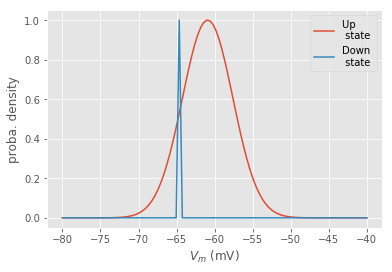

In [29]:
# let's have a look membrane potential distributions

vv = np.linspace(-80,-40,int(1e2))*1e-3
vm_up = gaussian_func(vv, mVm_up_cort, sVm_up_cort)
vm_down = gaussian_func(vv, mVm_down_cort, sVm_down_cort)

plt.plot(1e3*vv, vm_up/vm_up.max(), label="Up \n state")
plt.plot(1e3*vv, vm_down/vm_down.max(), label="Down \n state")
plt.xlabel('$V_m$ (mV)')
plt.ylabel('proba. density')
plt.legend();

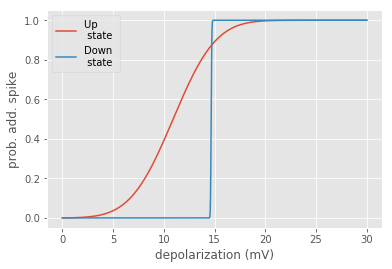

In [34]:
### ACTIVATION functions in the 2 states
## i.e. the spiking probability as a function of the evoked depolarization
stim = np.linspace(0,30,int(1e3))*1e-3 # depolarization in V (SI units)

prob_up = activation_prob(stim, mVm_up_cort, sVm_up_cort)
prob_down = activation_prob(stim, mVm_down_cort, sVm_down_cort)

plt.plot(1e3*stim, prob_up, label="Up \n state")
plt.plot(1e3*stim, prob_down, label="Down \n state")
plt.xlabel('depolarization (mV)')
plt.ylabel('prob. add. spike')
plt.legend();

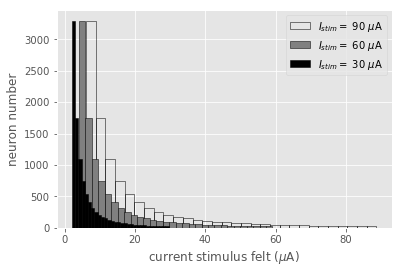

In [39]:
### Stimulus spread over the radial cortical network, because of the spatial attenuation
# of the currents neurons far will be surrounded by a tiny current, whereas the few
# close neurons will be very depolarized

s1, s2, s3 = 30, 60, 90
vec1, num1 = proba_density_I(s1, Ntot_cort, r0_cort, rmax_cort)
vec2, num2 = proba_density_I(s2, Ntot_cort, r0_cort, rmax_cort)
vec3, num3 = proba_density_I(s3, Ntot_cort, r0_cort, rmax_cort)

plt.bar(vec3, num3, width=vec3[1]-vec3[0], fill=False, edgecolor='k',
        label=r"$I_{stim}=$ "+str(s3)+" $\mu$A")
plt.bar(vec2, num2, width=vec2[1]-vec2[0], fill=True, color='gray', edgecolor='k',
        label=r"$I_{stim}=$ "+str(s2)+" $\mu$A")
plt.bar(vec1, num1, width=vec1[1]-vec1[0], fill=True, color='k', edgecolor='k',
        label=r"$I_{stim}=$ "+str(s1)+" $\mu$A")
plt.legend()
plt.xlabel(r"current stimulus felt ($\mu$A)")
plt.ylabel('neuron number');

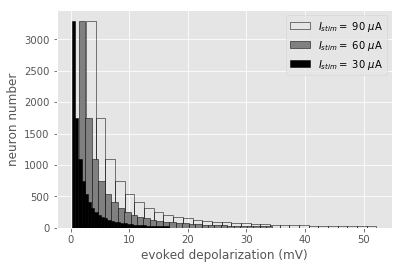

In [41]:
### now we translated those from extracellular currents into membrane depolarization

# parameter of the cortical stimulation translation, the heuristic function
parameters_cort_stimulation = [30, 17, 0.6] 

Vvec1 = current_to_depol(vec1, parameters_cort_stimulation)
Vvec2 = current_to_depol(vec2, parameters_cort_stimulation)
Vvec3 = current_to_depol(vec3, parameters_cort_stimulation)

plt.bar(Vvec3, num3, width=Vvec3[1]-Vvec3[0], fill=False, edgecolor='k',
        label=r"$I_{stim}=$ "+str(s3)+" $\mu$A")
plt.bar(Vvec2, num2, width=Vvec2[1]-Vvec2[0], fill=True, color='gray', edgecolor='k',
        label=r"$I_{stim}=$ "+str(s2)+" $\mu$A")
plt.bar(Vvec1, num1, width=Vvec1[1]-Vvec1[0], fill=True, color='k', edgecolor='k',
        label=r"$I_{stim}=$ "+str(s1)+" $\mu$A")
plt.xlabel(r"evoked depolarization (mV)")
plt.ylabel('neuron number')
plt.legend();

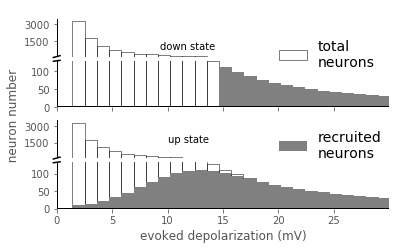

In [50]:
# now we illustrate the recruitment at one specific level of stimulation
level = 60 # uA, an intermediate level of electrical stim

# what we want to get, the number of recruited neurons:
num_activated_up, num_activated_down = [], []

# Histogram of depolarization across the network at that level
vec_down, num_down = proba_density_I(level, Navailable_down_cort, r0_cort, rmax_cort,
                                     discret=30)
# translated into membrane depolarization
stim_down = current_to_depol(vec_down, parameters_cort_stimulation)
# now the number of activated neurons is the number at a given depolarization multiplied
# by their probability to activate at that level (the quantity that depends on the flucts.)
for s in range(len(vec_down)):
    num_activated_down.append(activation_prob(1e-3*stim_down[s],\
                                              mVm_down_cort, sVm_down_cort)*num_down[s])
# same for up state
vec_up, num_up = proba_density_I(level, Navailable_up_cort, r0_cort, rmax_cort, discret=30)
stim_up = current_to_depol(vec_up, parameters_cort_stimulation) 
for s in range(len(vec_up)):
    num_activated_up.append(\
                    activation_prob(1e-3*stim_up[s], mVm_up_cort, sVm_up_cort)*num_up[s])

## ===========================================    
## From now on, only plotting...
## need to cut the axis, etc... so this takes quite some code
## ===========================================

x_min, x_max, up_max_bottom, down_max_bottom = 0, 30, 130, 130

# down state
ax1 = plt.subplot2grid((8,1), (0, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (2,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False);ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom();ax1.xaxis.tick_top();ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_down2 = [i if i>down_max_bottom else 0 for i in num_down]
ax1.bar(stim_down,num_down2,\
        width=stim_down[1]-stim_down[0], fill=False, edgecolor='k')
ax.bar(stim_down,np.fmin(num_down,np.ones(len(num_down))*1.2*down_max_bottom),\
        width=stim_down[1]-stim_down[0], fill=False, edgecolor='k', label="total\nneurons")
ax.bar(stim_down,num_activated_down,\
        width=stim_down[1]-stim_down[0], fill=True, color='gray')
ax.legend(loc=(.65,0.7), prop={'size':14}, frameon=False)

## set limits and ticks and annotations
ax1.set_ylim([down_max_bottom,1.3*max(num_down)])
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,down_max_bottom-1])
ax1.set_yticks([1500, 3000]);ax.set_yticks([0,50,100])
ax.set_xticks([0,5,10,15,20,25]);ax.set_xticklabels(["","","","","",""])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))

# up state
ax1 = plt.subplot2grid((8,1), (4, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (6,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom()
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_up2 = [i if i>up_max_bottom else 0 for i in num_up]
ax1.bar(stim_up,num_up2,\
        width=stim_up[1]-stim_up[0], fill=False, edgecolor='k')
ax.bar(stim_up,np.fmin(num_up,np.ones(len(num_up))*1.2*up_max_bottom),\
        width=stim_up[1]-stim_up[0], fill=False, edgecolor='k')
ax.bar(stim_up,num_activated_up,\
        width=stim_up[1]-stim_up[0], fill=True, color='gray', label='recruited\nneurons')

ax.set_xlabel(r"evoked depolarization (mV)")
ax1.set_ylabel('          neuron number')
ax.legend(loc=(.65,0.92), prop={'size':14}, frameon=False)

## set limits and ticks and annotations
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,up_max_bottom+2])
ax1.set_yticks([1500, 3000]);ax.set_yticks([0,50,100])
ax.set_xticks([0,5,10,15,20,25])
ax1.set_ylim([up_max_bottom,1.3*max(num_up)])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal

ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))
plt.annotate(r"up state", (.42,.43), xycoords='figure fraction')
plt.annotate(r"down state", (.4,.8), xycoords='figure fraction')
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9);

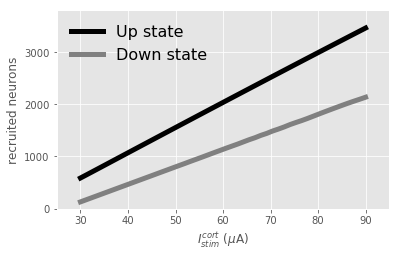

In [52]:
### now total number of activated neurons per stimulus value

stim_intensity = np.linspace(30, 90)
recruit_up, recruit_down = [], []

# Same than before for all stimuli level 
for s in stim_intensity:
    
    
    # down_state
    vec_down, num_down = proba_density_I(s, Navailable_down_cort, r0_cort, rmax_cort,\
                                         discret=200)
    stim_down = current_to_depol(vec_down, parameters_cort_stimulation)
    num_activated_down = []
    for nrns in range(len(vec_down)):
        num_activated_down.append(activation_prob(1e-3*stim_down[nrns], mVm_down_cort,
                                                  sVm_down_cort)*num_down[nrns])
        
    # up_state
    vec_up, num_up = proba_density_I(s, Navailable_up_cort, r0_cort, rmax_cort, discret=200)
    stim_up = current_to_depol(vec_up, parameters_cort_stimulation)
    num_activated_up = []
    for nrns in range(len(vec_up)):
        num_activated_up.append(activation_prob(1e-3*stim_up[nrns],
                                                mVm_up_cort, sVm_up_cort)*num_up[nrns])
        
    # then we just sum the number of activated neurons
    recruit_down.append(np.array(num_activated_down).sum())
    recruit_up.append(np.array(num_activated_up).sum())

fig, ax = plt.subplots()
plt.plot(stim_intensity, recruit_up, 'k-', lw=5, label='Up state')
plt.plot(stim_intensity, recruit_down, '-', color='gray', lw=5, label='Down state')
plt.legend(loc='upper left', prop={'size':16}, frameon=False)
plt.ylabel('recruited neurons'); plt.xlabel(r"$I_{stim}^{cort}$ ($\mu$A)")
ax.set_xlim([25,95]);ax.set_xticks([30,40,50,60,70,80,90])
ax.set_yticks([0,1e3,2e3,3e3])
ax.set_ylim([0,38e2])
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)

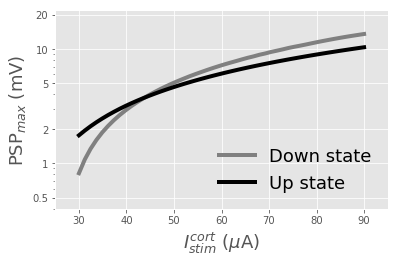

In [56]:
### now we compute the PSP size from those activated neurons number for each stimulus value
### Here as well, there is an effect of the network state because of the different input
### conductances
v_max_up_cort, v_max_down_cort = [], []

# UPDATED, for accurate determination of the max, much better than a newton method actually
t = np.linspace(0,50,int(1e4)) 
for i in range(len(stim_intensity)):
    # down state
    Nexc_down, Ninh_down = connectivity*recruit_down[i]*(1-g), connectivity*recruit_down[i]*g
    epsp_down = PSP(t, Nexc_down, Qe, Te, Tm_down_cort, Cm, Ee, mVm_down_cort) 
    ipsp_down = PSP(t, Ninh_down, Qi, Ti, Tm_down_cort, Cm, Ei, mVm_down_cort) 
    v_max_down_cort.append(1e3*max(epsp_down+ipsp_down))
    # up state 
    Nexc_up, Ninh_up = connectivity*recruit_up[i]*(1-g), connectivity*recruit_up[i]*g
    epsp_up = PSP(t, Nexc_up, Qe, Te, Tm_up_cort, Cm, Ee, mVm_up_cort) 
    ipsp_up = PSP(t, Ninh_up, Qi, Ti, Tm_up_cort, Cm, Ei, mVm_up_cort) 
    v_max_up_cort.append(1e3*max(epsp_up+ipsp_up))
    
fig, ax = plt.subplots()
ax.semilogy(stim_intensity, v_max_down_cort, lw=4, color='gray', label='Down state')
ax.semilogy(stim_intensity, v_max_up_cort, lw=4, color='k', label='Up state')
ax.set_yticks([0.1, 0.5, 1, 2, 5, 10, 20])
ax.set_ylim([0.4, 22])
ax.set_xlim([25,95]);ax.set_xticks([30,40,50,60,70,80,90])
ax.set_ylabel(r"PSP$_{max}$ (mV)", fontsize='18')
ax.set_xlabel(r"$I_{stim}^{cort}$ ($\mu$A)", fontsize='18')
ax.set_yticklabels(["0.1", "0.5", "1", "2", "5", "10", "20"])
plt.legend(loc='lower right', prop={'size':18}, frameon=False)
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)

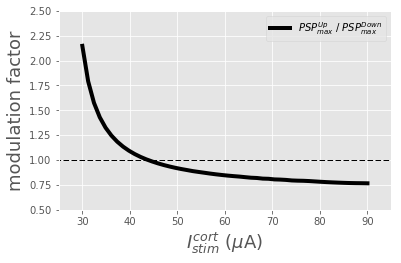

In [60]:
# now we just plot the 'modulation factor', the ratio between up state and down state responses
fig, ax = plt.subplots()
ax.plot([10,120], [1,1], '--', lw=1, color='k')
ax.plot(stim_intensity, np.array(v_max_up_cort)/np.array(v_max_down_cort), lw=4, color='k',\
        label="$PSP_{max}^{Up}$ $/$ $PSP_{max}^{Down}$")
ax.set_xlim([25,95]);ax.set_xticks([30,40,50,60,70,80,90])
ax.set_ylim([0.5, 2.5])
ax.set_ylabel(r"modulation factor", fontsize='18')
ax.set_xlabel(r"$I_{stim}^{cort}$ ($\mu$A)", fontsize='18')
plt.legend()
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)

## Now thalamo-cortical model

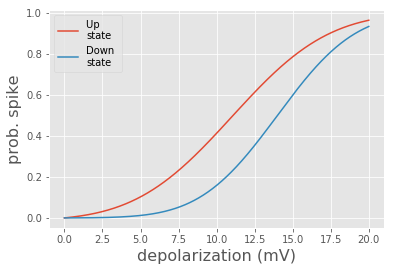

In [65]:
### we start with the activation function of the thalamus
## the difference between up and down state is more subtle in the
## thalamus (Contreras et al., 96) so the activation function will look
## more similar

stim = np.linspace(0,20,int(1e3))*1e-3

prob_up_thal = activation_prob(stim, mVm_up_thal, sVm_up_thal)
prob_down_thal = activation_prob(stim, mVm_down_thal, sVm_down_thal)

plt.plot(1e3*stim, prob_up_thal, label="Up \nstate")
plt.plot(1e3*stim, prob_down_thal, label="Down \nstate")
plt.xlabel('depolarization (mV)', fontsize='16')
plt.ylabel('prob. spike', fontsize='16')
plt.legend();

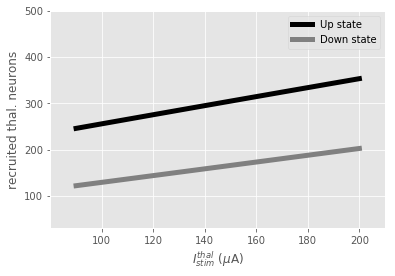

In [68]:
### Same than before for the cortex,
## we want the total number of activated neurons in the thalamus per stimulus value
recruit_up_thal, recruit_down_thal = [], []

stim_intensity_thal = np.linspace(90,200)
parameters_thal_stimulation = [90, 18, 0.21] # parameter of the heuristic function

for s in stim_intensity_thal:
    # then histogram of depolarization
    
    # down_state
    vec_down, num_down = proba_density_I(s, Navailable_down_thal,
                                         r0_thal, rmax_thal, thal=True, discret=200)
    stim_down = current_to_depol(vec_down, parameters_thal_stimulation)
    num_activated_down = []
    for nrns in range(len(vec_down)):
        num_activated_down.append(activation_prob(1e-3*stim_down[nrns],
                                                  mVm_down_thal, sVm_down_thal)*num_down[nrns])
    recruit_down_thal.append(np.array(num_activated_down).sum())
    # up_state
    vec_up, num_up = proba_density_I(s, Navailable_up_thal,
                                     r0_thal, rmax_thal, thal=True, discret=200)
    stim_up = current_to_depol(vec_up, parameters_thal_stimulation)
    num_activated_up = []
    for nrns in range(len(vec_up)):
        num_activated_up.append(activation_prob(1e-3*stim_up[nrns],
                                                mVm_up_thal, sVm_up_thal)*num_up[nrns])
    recruit_up_thal.append(np.array(num_activated_up).sum())


plt.plot(stim_intensity_thal, recruit_up_thal, 'k-', lw=5, label='Up state')
plt.plot(stim_intensity_thal, recruit_down_thal, '-', color='gray', lw=5, label='Down state')
plt.ylabel('recruited thal. neurons'); plt.xlabel(r"$I_{stim}^{thal}$ ($\mu$A)")
plt.xlim([80,210]);plt.xticks([100, 120, 140, 160, 180, 200])
plt.ylim([30,500])
plt.legend();

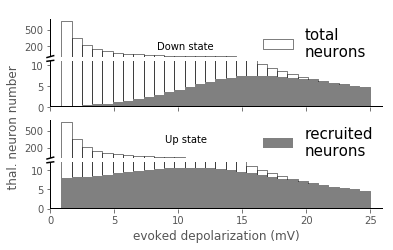

In [77]:
# as for the cortex,  we illustrate the recruitment at one specific level of stimulation

level = 145 # uA

# then histogram of depolarization
vec_down, num_down = proba_density_I(level, Navailable_down_thal, r0_thal, rmax_thal, thal=True)
stim_down = current_to_depol(vec_down, parameters_thal_stimulation) # translated into membrane depol

vec_up, num_up = proba_density_I(level, Navailable_up_thal, r0_thal, rmax_thal, thal=True)
stim_up = current_to_depol(vec_up, parameters_thal_stimulation) # translated into membrane depol

num_activated_up, num_activated_down = [], []
for s in range(len(vec_up)):
    num_activated_up.append(activation_prob(1e-3*stim_up[s], mVm_up_thal, sVm_up_thal)*num_up[s])
for s in range(len(vec_down)):
    num_activated_down.append(activation_prob(1e-3*stim_down[s], mVm_down_thal, sVm_down_thal)*num_down[s])

##=========================================
##       plotting for now on
##=========================================

x_min, x_max, up_max_bottom, down_max_bottom = 0, 26, 12, 12

# down state
ax1 = plt.subplot2grid((8,1), (0, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (2,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False);ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom();ax1.xaxis.tick_top();ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_down2 = [i if i>down_max_bottom else 0 for i in num_down]
ax1.bar(stim_down,num_down2,\
        width=stim_down[1]-stim_down[0], fill=False, edgecolor='k')
ax.bar(stim_down,np.fmin(num_down,np.ones(len(num_down))*1.2*down_max_bottom),\
        width=stim_down[1]-stim_down[0], fill=False, edgecolor='k', label="total\nneurons")
ax.bar(stim_down,num_activated_down,\
        width=stim_down[1]-stim_down[0], fill=True, color='gray')

#ax.set_ylabel(r" cort. neuron #")
ax.legend(loc=(.62,0.9), prop={'size':15}, frameon=False)

## set limits and ticks and annotations
ax1.set_ylim([down_max_bottom,1.3*max(num_down)])
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,down_max_bottom-1])
ax1.set_yticks([200,500]);ax.set_yticks([0,5,10])
ax.set_xticks([0,5,10,15,20,25]);ax.set_xticklabels(["","","","","",""])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))


# up state
ax1 = plt.subplot2grid((8,1), (4, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (6,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom()
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_up2 = [i if i>up_max_bottom else 0 for i in num_up]
ax1.bar(stim_up,num_up2,\
        width=stim_up[1]-stim_up[0], fill=False, edgecolor='k')
ax.bar(stim_up,np.fmin(num_up,np.ones(len(num_up))*1.2*up_max_bottom),\
        width=stim_up[1]-stim_up[0], fill=False, edgecolor='k')
ax.bar(stim_up,num_activated_up,\
        width=stim_up[1]-stim_up[0], fill=True, color='gray', label='recruited\nneurons')

ax.set_xlabel(r"evoked depolarization (mV)")
ax1.set_ylabel('    thal. neuron number')
ax.legend(loc=(.62,0.95), prop={'size':15}, frameon=False)

## set limits and ticks and annotations
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,up_max_bottom])
ax1.set_yticks([200,500]);ax.set_yticks([0,5,10])
ax.set_xticks([0,5,10,15,20,25])
ax1.set_ylim([up_max_bottom,1.3*max(num_up)])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
#plt.annotate(r"$I_{stim}=$ "+str(level)+" $\mu$A", (.3,.75), textcoords='figure fraction', size='small')
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))
plt.annotate(r"Up state", (.42,.43), xycoords='figure fraction')
plt.annotate(r"Down state", (.4,.8), xycoords='figure fraction')
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)

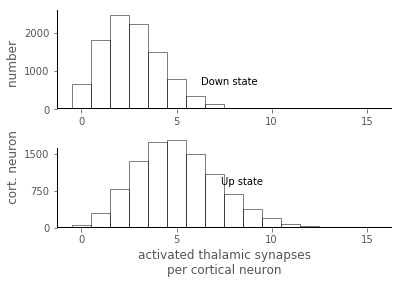

In [79]:
### now for the same example of the previous thalamic stim value
### we have a value of activated neurons, this number will be spread over
### the cortical neurons according the binomial distribution to determine the
### number of activated synapses

num_up_thal, num_down_thal = num_activated_up, num_activated_down

from scipy.stats import binom

n_activated_up = np.array(num_up_thal).sum()
n_activated_down = np.array(num_down_thal).sum()
x = np.arange(16) # abcisse of number per synapses
HIST_activated_syn_up = binom.pmf(x, n_activated_up, thal_connec)*Ntot_cort
HIST_activated_syn_down = binom.pmf(x, n_activated_down, thal_connec)*Ntot_cort

##=========================================
##       plotting for now on
##=========================================

ax = plt.subplot(211,frameon=False)
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
plt.bar(x,HIST_activated_syn_down,width=x[1]-x[0],edgecolor='k', fill=False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
plt.ylabel("number  ")
ax.set_yticks([0,1000,2000]);ax.set_xticks([0,5,10,15])

ax = plt.subplot(212,frameon=False)
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
plt.bar(x,HIST_activated_syn_up,width=x[1]-x[0],edgecolor='k', fill=False)
ax.set_ylim([0,2000])
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, .8*ymax), color='black', linewidth=2))
plt.ylabel("      cort. neuron")
plt.xlabel("activated thalamic synapses\nper cortical neuron")
ax.set_yticks([0,750,1500]);ax.set_xticks([0,5,10,15])

plt.annotate(r"Up state", (.55,.35), xycoords='figure fraction')
plt.annotate(r"Down state", (.5,.7), xycoords='figure fraction');

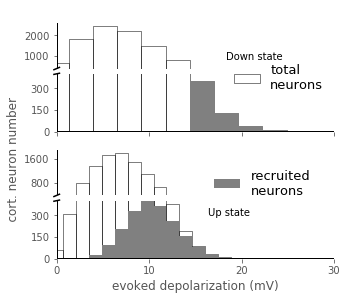

In [85]:
# now for each of this synaptic number we need to calculate the PSP size (depol !) to get
# the histogram of the depol in the network

depol_up, depol_down = [], []
activated_up, activated_down = [], []
t = 1e-3*np.linspace(0,50,int(1e4))

for i in range(len(x)): # x is number of activated synapses
    # up state
    max_depol = PSP(t, x[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort).max()
    number = HIST_activated_syn_up[i]
    depol_up.append(1e3*max_depol)
    activated_up.append(activation_prob(max_depol, mVm_up_cort, sVm_up_cort)*number)
    # down state
    max_depol = PSP(t, x[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort).max()
    number = HIST_activated_syn_down[i]
    depol_down.append(1e3*max_depol)
    activated_down.append(activation_prob(max_depol, mVm_down_cort, sVm_down_cort)*number)
depol_up, depol_down = np.array(depol_up), np.array(depol_down)    
activated_up, activated_down = np.array(activated_up), np.array(activated_down)    


##=========================================
##       plotting for now on
##=========================================

x_min, x_max, up_max_bottom, down_max_bottom = 0, 30, 400, 400

plt.figure(figsize=(5,5))

# down state
ax1 = plt.subplot2grid((8,1), (0, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (2,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False);ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom();ax1.xaxis.tick_top();ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_down2 = [i if i>down_max_bottom else 0 for i in HIST_activated_syn_down]
ax1.bar(depol_down,num_down2,\
        width=depol_down[1]-depol_down[0], fill=False, edgecolor='k')
ax.bar(depol_down,np.fmin(HIST_activated_syn_down,np.ones(len(HIST_activated_syn_down))*1.2*down_max_bottom),\
        width=depol_down[1]-depol_down[0], fill=False, edgecolor='k', label="total\nneurons")
ax.bar(depol_down,activated_down,\
        width=depol_down[1]-depol_down[0], fill=True, color='gray')


ax.legend(loc=(.62,0.6), prop={'size':13}, frameon=False)

## set limits and ticks and annotations
ax1.set_ylim([down_max_bottom,1.3*max(HIST_activated_syn_down)])
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,down_max_bottom-1])
ax1.set_yticks([1000,2000]);ax.set_yticks([0,150,300])
ax.set_xticks([0,10,20,30]);ax.set_xticklabels(["","","",""])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))


# up state
ax1 = plt.subplot2grid((8,1), (4, 0), rowspan=2, frameon=False) # TOP
ax = plt.subplot2grid((8,1), (6,0), rowspan=2, sharex=ax1, frameon=False) # BOTTOM
ax.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax.xaxis.tick_bottom()
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off') # don't put tick labels at the top

num_up2 = [i if i>up_max_bottom else 0 for i in HIST_activated_syn_up]
ax1.bar(depol_up,num_up2,\
        width=depol_up[1]-depol_up[0], fill=False, edgecolor='k')
ax.bar(depol_up,np.fmin(HIST_activated_syn_up,np.ones(len(HIST_activated_syn_up))*1.2*up_max_bottom),\
        width=depol_up[1]-depol_up[0], fill=False, edgecolor='k')
ax.bar(depol_up,activated_up,\
        width=depol_up[1]-depol_up[0], fill=True, color='gray', label='recruited\nneurons')

ax.set_xlabel(r"evoked depolarization (mV)")
ax1.set_ylabel('    cort. neuron number')
ax.legend(loc=(.55,0.97), prop={'size':13}, frameon=False)

## set limits and ticks and annotations
ax1.set_xlim([x_min,x_max]);ax.set_xlim([x_min,x_max])
ax.set_ylim([0,up_max_bottom+2])
ax1.set_yticks([800,1600]);ax.set_yticks([0,150,300])
ax.set_xticks([0,10,20,30])
ax1.set_ylim([up_max_bottom,1.3*max(HIST_activated_syn_up)])

### then dealing with cutting the axes
d = 1e-2 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d),(-2*d,+2*d), **kwargs)      # top-left diagonal
kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
ax.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
#plt.annotate(r"$I_{stim}=$ "+str(level)+" $\mu$A", (.3,.75), textcoords='figure fraction', size='small')
ax.get_xaxis().tick_bottom();ax.get_yaxis().tick_left()
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
ax1.axes.get_xaxis().set_visible(False);ax1.get_yaxis().tick_left()
xmin, xmax = ax1.get_xaxis().get_view_interval()
ymin, ymax = ax1.get_yaxis().get_view_interval()
ax1.add_artist(plt.Line2D((xmin, xmin), (ymin, 0.8*ymax), color='black', linewidth=2))
plt.annotate(r"Up state", (.6,.28), xycoords='figure fraction')
plt.annotate(r"Down state", (.65,.8), xycoords='figure fraction')

plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)

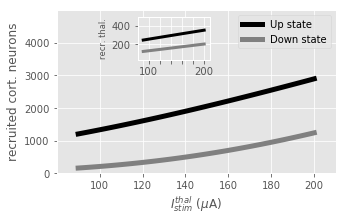

In [90]:
### now we generalize this approach for all stimulus values

x = np.arange(50) # abcisse of number per synapses
t = 1e-3*np.linspace(0,50,int(1e4))

activated_cort_up, activated_cort_down = [], []

for i in range(len(stim_intensity_thal)):
    
    vec_down, num_down = proba_density_I(stim_intensity_thal[i], Navailable_down_thal, r0_thal, rmax_thal, thal=True)
    stim_down = current_to_depol(vec_down, parameters_thal_stimulation) # translated into membrane depol

    vec_up, num_up = proba_density_I(stim_intensity_thal[i], Navailable_up_thal, r0_thal, rmax_thal, thal=True)
    stim_up = current_to_depol(vec_up, parameters_thal_stimulation) # translated into membrane depol

    num_activated_up, num_activated_down = [], []
    for s in range(len(vec_up)):
        num_activated_up.append(activation_prob(1e-3*stim_up[s], mVm_up_thal, sVm_up_thal)*num_up[s])
    for s in range(len(vec_down)):
        num_activated_down.append(activation_prob(1e-3*stim_down[s], mVm_down_thal, sVm_down_thal)*num_down[s])

    # so the total recuited neurons are
    n_activated_up = np.array(num_activated_up).sum() # we end up with a single number for both
    n_activated_down = np.array(num_activated_down).sum()
    # ---- then we spread the activated synapses onto the cortical neurons
    HIST_activated_syn_up = binom.pmf(x, n_activated_up, thal_connec)*Ntot_cort
    HIST_activated_syn_down = binom.pmf(x, n_activated_down, thal_connec)*Ntot_cort
    
    # now for each of this synaptic number we need to calculate the PSP size (depol !)
    activated_up, activated_down = [], []
    for i in range(len(x)): # x is number of activated synapses
        # up state
        max_depol = PSP(t, x[i], Qe_thal, Te_thal, Tm_up_cort, Cm, Ee, mVm_up_cort).max()
        activated_up.append(activation_prob(max_depol, mVm_up_cort, sVm_up_cort)*HIST_activated_syn_up[i])
        # down state
        max_depol = PSP(t, x[i], Qe_thal, Te_thal, Tm_down_cort, Cm, Ee, mVm_down_cort).max()
        activated_down.append(activation_prob(max_depol, mVm_down_cort, sVm_down_cort)*HIST_activated_syn_down[i])

    N_activated_cort_up, N_activated_cort_down = np.array(activated_up).sum(), np.array(activated_down).sum()
    activated_cort_up.append(N_activated_cort_up)
    activated_cort_down.append(N_activated_cort_down)
    
fig = plt.figure(figsize=(5,3))
    
ax = plt.subplot(111)
plt.plot(stim_intensity_thal, activated_cort_up, 'k-', lw=5, label='Up state')
plt.plot(stim_intensity_thal, activated_cort_down, '-', color='gray', lw=5, label='Down state')
plt.legend()
plt.ylabel('recruited cort. neurons'); plt.xlabel(r"$I_{stim}^{thal}$ ($\mu$A)")
ax.set_xlim([80,210]);ax.set_ylim([0, 5000])
ax.set_xticks([100, 120, 140, 160, 180, 200])
ax.set_yticks([0, 1000, 2000, 3000,4000])

ax2 = plt.axes((0.35,.65,.2,.2))
plt.plot(stim_intensity_thal, recruit_up_thal, 'k-', lw=3)
plt.plot(stim_intensity_thal, recruit_down_thal, '-', color='gray', lw=3)
plt.ylabel('recr. thal.', size='small')
ax2.set_xlim([80,210])
ax2.set_xticks([100, 120, 140, 160, 180, 200])
ax2.set_xticklabels(['100','','','','','200'])
ax2.set_ylim([30,500]);ax2.set_yticks([200,400])
ax2.set_xticks([100, 120, 140, 160, 180, 200]);


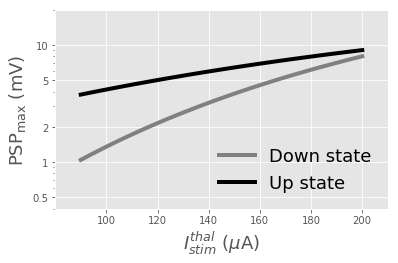

In [91]:
### now we compute the PSP size from those activated neurons number
v_max_up_thal, v_max_down_thal = [], []

for i in range(len(stim_intensity_thal)):
    # down state
    Nexc_down = connectivity*activated_cort_down[i]*(1-g)
    Ninh_down = connectivity*activated_cort_down[i]*g
    epsp = 1e3*PSP(t, Nexc_down, Qe, Te, Tm_down_cort, Cm, Ee, mVm_down_cort)
    ipsp = 1e3*PSP(t, Ninh_down, Qi, Ti, Tm_down_cort, Cm, Ei, mVm_down_cort)   
    v_max_down_thal.append(max(epsp+ipsp))
    Nexc_up = connectivity*activated_cort_up[i]*(1-g)
    Ninh_up = connectivity*activated_cort_up[i]*g
    epsp = 1e3*PSP(t, Nexc_up, Qe, Te, Tm_up_cort, Cm, Ee, mVm_up_cort)
    ipsp = 1e3*PSP(t, Ninh_up, Qi, Ti, Tm_up_cort, Cm, Ei, mVm_up_cort)   
    v_max_up_thal.append(max(epsp+ipsp))
    
ax = plt.subplot(111)
ax.semilogy(stim_intensity_thal, v_max_down_thal, lw=4, color='gray', label='Down state')
ax.semilogy(stim_intensity_thal, v_max_up_thal, lw=4, color='k', label='Up state')
ax.set_yticks([0.5, 1, 2, 5, 10])
ax.set_ylim([0.4,20])
#ax.set_xlim([25,95]);ax.set_xticks([30,40,50,60,70,80,90])
ax.set_ylabel(r"PSP$_\max$ (mV)", fontsize='18')
ax.set_xlabel(r"$I_{stim}^{thal}$ ($\mu$A)", fontsize='18')
ax.set_yticklabels(["0.5", "1", "2", "5", "10"])
ax.set_xlim([80,210])
ax.set_xticks([100, 120, 140, 160, 180, 200])
plt.legend(loc='lower right', prop={'size':18}, frameon=False)
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)


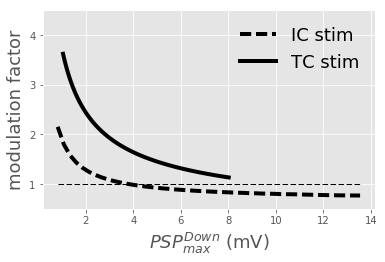

In [94]:
## Finally, we plot the factor of the thalamic modulation and compare it with the cortical one

ax = plt.subplot(111)
x_min = min([min(v_max_down_thal),min(v_max_down_cort)])
x_max = max([max(v_max_down_thal),max(v_max_down_cort)])

ax.plot([x_min,x_max], [1,1], '--', lw=1, color='k')
ax.plot(v_max_down_cort, np.array(v_max_up_cort)/np.array(v_max_down_cort), '--', lw=4, color='k', label='IC stim')
ax.plot(v_max_down_thal, np.array(v_max_up_thal)/np.array(v_max_down_thal), lw=4, color='k', label='TC stim')
ax.set_ylim([0.5, 4.5])
ax.set_ylabel(r"modulation factor", fontsize='18')
ax.set_xlabel(r"$PSP_{max}^{Down}$ (mV)", fontsize='18')
ax.set_yticks([1,2,3,4])
plt.legend(loc='best', prop={'size':18}, frameon=False)
plt.subplots_adjust(hspace=None, left=0.18, bottom=0.21, right=0.95, top =0.9)